In [155]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# import adastra

In [156]:
%load_ext autoreload
%autoreload 1
%aimport adastra

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
fa17missing = [
    ('OIE1000', 5/3),  # OIE
    ('ENGR3590', 10/3),  # CompRobo
    ('AHSE1148', 10/3),  # DIRT TO SHIRT
    ('ENGR3590', 3),  # ADE
    ('ENGR3240', 16/3),  # TELL THE STORY
    ('MTH2132', 10/3),  # BAYESIAN
    ('AHSE1100', 10/3),  # HISTECH
    ('ENGR3299', 8),  # RETURN DESIGN
]
sp18missing = [
    ('ENGR3299', 10/3),  # BIOMIMICRY
    ('ENGR3599A', 10/3),  # HTL
    ('ENGR3299B', 8),  # RETURN DESIGN
]
tup_to_dict = lambda a: [{'Course/Customer': code, 'Weekly Length': pd.to_timedelta(hours, unit='h')} for code, hours in a]
fa17missing, sp18missing = tuple(tup_to_dict(l) for l in [fa17missing, sp18missing])

In [158]:
fa17courses = adastra.load_schedule_file('data/ad astra test fa17.xls')
sp18courses = adastra.load_schedule_file('data/ad astra test sp18.xls')

WARNING *** file size (190919) not 512 + multiple of sector size (512)
WARNING *** file size (222207) not 512 + multiple of sector size (512)


In [159]:
add_missing = lambda a, m: pd.concat([a, pd.DataFrame(m)], sort=True, ignore_index=False).reset_index()
fa17courses = add_missing(fa17courses, fa17missing)
sp18courses = add_missing(sp18courses, sp18missing)
fa17courses[-10:]

,index,Activity Type,Building,Campus,Contact/Instructor,Course/Customer,Days,End Date,End Time,Enroll,Length,Room,Section,Start Date,Start Time,Status,Subj/Reservation,Title,Weekly Length
64,560,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,R,2017-12-08,15:10:00,24.0,02:10:00,428,03,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
65,561,Section,AC,Olin,"Hill, Benjamin Thomas",ENGR1125,F,2017-12-08,15:10:00,24.0,02:10:00,428,04,2017-08-31,13:00:00,Scheduled,ENGR,"Introduction to Sensors,",02:10:00
66,0,NaN,NaN,NaN,NaN,OIE1000,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,01:40:00.000001
67,1,NaN,NaN,NaN,NaN,ENGR3590,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
68,2,NaN,NaN,NaN,NaN,AHSE1148,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
69,3,NaN,NaN,NaN,NaN,ENGR3590,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:00:00
70,4,NaN,NaN,NaN,NaN,ENGR3240,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,05:19:59.999998
71,5,NaN,NaN,NaN,NaN,MTH2132,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
72,6,NaN,NaN,NaN,NaN,AHSE1100,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,03:19:59.999998
73,7,NaN,NaN,NaN,NaN,ENGR3299,NaN,NaT,NaT,NaN,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,08:00:00


In [160]:
fa17cat = pd.read_csv('Class and Room Categorization - Classes Fall 2017.csv', usecols=range(13))
fa17cat.drop_duplicates(subset='Course Code', inplace=True)
sp18cat = pd.read_csv('Class and Room Categorization - Classes Spring 2018.csv', usecols=range(13))
sp18cat.drop_duplicates(subset='Course Code', inplace=True)

In [161]:
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def to_int(text):
    return int(text.strip('" '))

def getEnrollment(filename):
    enrollment = pd.read_csv(
        filename,
        usecols=[2,9],
        converters = {'Crs No' : strip, 'Registered Students' : to_int})
    enrollment.drop_duplicates(subset='Crs No', inplace=True)
    return enrollment

In [162]:
fa17enrollment = getEnrollment('FA17_Enrollment.csv')
sp18enrollment = getEnrollment('SP18_Enrollment.csv')

In [163]:
category_colors = {  # map for category colors
    'PROJECT - BASED - 3d': '#1155cc',
    'PROJECT - BASED - 2d': '#3c78d8',
    'PROJECT - BASED - digital': '#6d9eeb',
    'LECTURE': '#e69138',
    'LAB': '#38761d',
    'NOT IN AC': '#cc0000',
    'DISCUSSION': '#674ea7'
}

category_names = {  # map for category names
    'PROJECT - BASED - 3d': 'project-based 3d',
    'PROJECT - BASED - 2d': 'project-based 2d',
    'PROJECT - BASED - digital': 'project-based digital',
    'LECTURE': '"lecture"',
    'LAB': 'lab',
    'DISCUSSION': 'discussion'
}

def merge(sched, cat, enrollment, sched_code='Course/Customer', cat_code='Course Code', en_code='Crs No'):

#     def agg_time(frame, group_col, agg_col):
#         return frame.groupby(group_col, as_index=False)[agg_col].agg(np.sum)

    merge1 = pd.merge(
        left=sched,
        right=cat,
        how='left',
        left_on=sched_code,
        right_on=cat_code,
        indicator=True,
#         validate='one_to_many'
    )
    
    return pd.merge(
        left=merge1,
        right=enrollment,
        how='inner',
        left_on=sched_code,
        right_on=en_code,
        indicator='exists'
    )

agg_by_time = lambda a: a.groupby('Course/Customer', as_index=False)['Weekly Length'].agg(np.sum)
# agg_by_time_normalized = lambda a: a.groupby('Primary Category', as_index=False).agg({'Weekly Length':'sum', 
#                          'Registered Students':'sum'})

def plot_pie_cat_totals(courses, group_col='Primary Category', agg_col='Weekly Length', fig=None, normalize=False, norm_col=None):
    if normalize:
        cat_totals = courses.groupby(group_col, as_index=False).agg({'Weekly Length':['sum'], 
                         'Registered Students':'sum'})
        pie_data = (cat_totals[agg_col]['sum'] / pd.Timedelta(1, unit='h'))/cat_totals[norm_col]['sum']
    else:
        cat_totals = courses.groupby(group_col, as_index=False)[agg_col].agg(np.sum)
        pie_data = cat_totals[agg_col] / pd.Timedelta(1,unit='h')
#     cat_totals.sort_values('Weekly Length', inplace=True)  # sort by value
    cat_totals.sort_values('Primary Category', inplace=True)  # sort by label
    
    # fig = plt.figure()
    return adastra.plot_pie(
        pie_data,
        labels=[category_names.get(category, category) for category in cat_totals[group_col]],
        colors=[category_colors.get(category, 'grey') for category in cat_totals[group_col]],
        fig=fig
        )

## Plot pie charts of courses per semester

In [164]:
cat_cols = ['Course Code','Course Title','Primary Category','Seconday Category']
fa17footprint, sp18footprint = tuple(merge(agg_by_time(sched), cat[cat_cols], enrollment) for sched, cat, enrollment in [(fa17courses, fa17cat, fa17enrollment),(sp18courses, sp18cat, sp18enrollment)])





                                                                                                                         

Check for missed courses

In [165]:
fa17footprint[fa17footprint['_merge'] == 'right_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge,Crs No,Registered Students,exists


In [166]:
fa17footprint[fa17footprint['exists'] == 'left_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge,Crs No,Registered Students,exists


In [167]:
sp18footprint[sp18footprint['exists'] == 'left_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge,Crs No,Registered Students,exists


In [168]:
sp18footprint[sp18footprint['_merge'] == 'right_only']

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge,Crs No,Registered Students,exists


### Space Usage

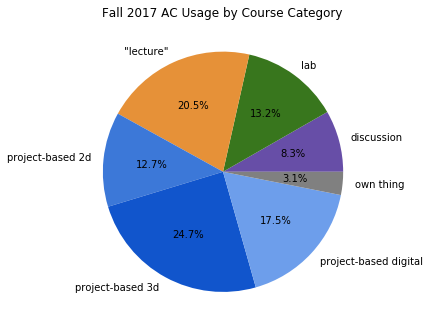

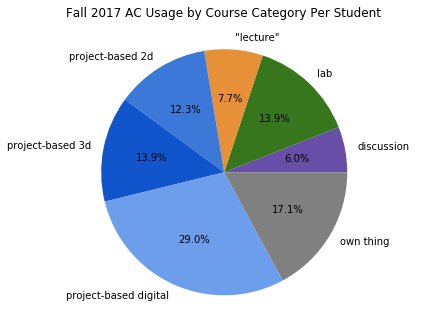

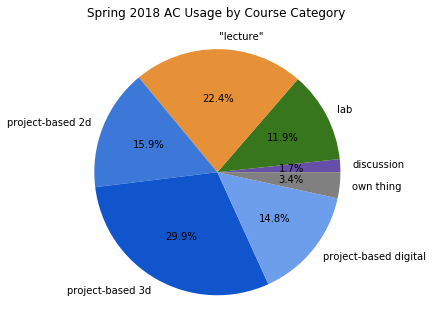

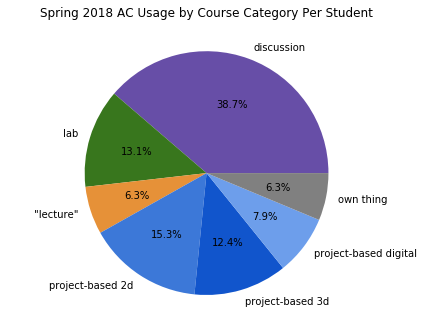

In [169]:
footprints = [
    ('Fall 2017', fa17footprint),
    ('Spring 2018', sp18footprint)
]
for name, data in footprints:
    fig = plt.figure(figsize=(7,5))
    plt.title(name+' AC Usage by Course Category', y=1.05)
    plot_pie_cat_totals(data[data['Primary Category'] != 'NOT IN AC'], fig=fig, normalize=False)
    plt.savefig('figs/'+name.lower().strip(' ')+'_footprint'+'.eps')
    
    fig2 = plt.figure(figsize=(7,5))
    plt.title(name+' AC Usage by Course Category Per Student', y=1.05)
    plot_pie_cat_totals(data[data['Primary Category'] != 'NOT IN AC'], fig=fig2, normalize=True, norm_col='Registered Students')
    plt.savefig('figs/'+name.lower().strip(' ')+'_footprint'+'.eps')

### Course Offerings

In [171]:
agg_by_course = lambda a: a.groupby('Primary Category', as_index=False)['Course/Customer'].agg('count')
agg_by_course_normed = lambda a: a.groupby('Primary Category', as_index=False).agg({'Course/Customer':['count'], 
                         'Registered Students':'sum'})

In [ ]:
fa17footprint[fa17footprint['Primary Category'] != 'NOT IN AC']

In [172]:
agg_by_course_normed(sp18footprint)

,Primary Category,Course/Customer,Registered Students
,,count,sum
0,DISCUSSION,1,3
1,LAB,3,62
2,LECTURE,11,240
3,NOT IN AC,1,7
4,PROJECT - BASED - 2d,3,71
5,PROJECT - BASED - 3d,11,164
6,PROJECT - BASED - digital,4,127
7,own thing,2,37


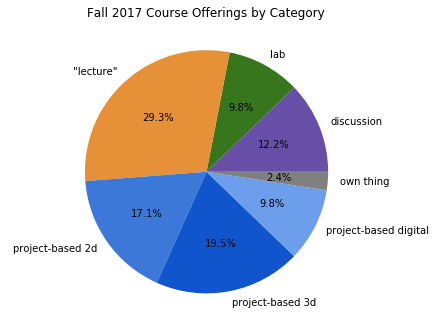

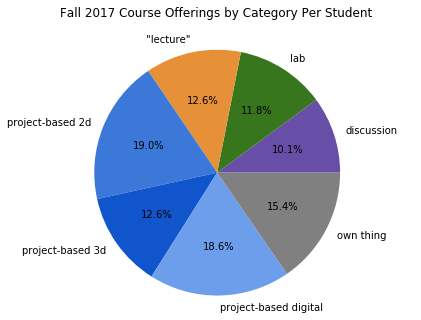

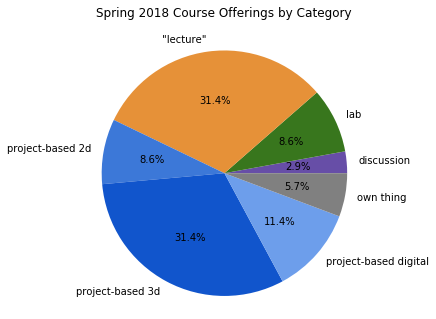

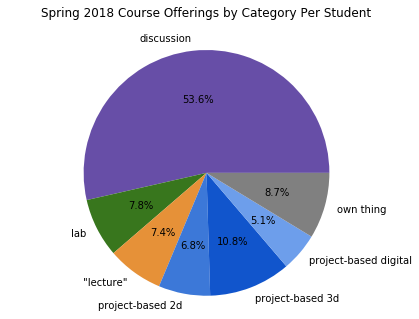

In [173]:
for name, data in footprints:
    for normed in [False, True]:
        fig = plt.figure(figsize=(7,5))
        if normed:
            plt.title(name+' Course Offerings by Category Per Student', y=1.05)
            cat_totals = agg_by_course_normed(data[data['Primary Category'] != 'NOT IN AC'])
            # Had to multiply by 100 here to prevent pie plotting from interpreting decimals 
            pie_data = cat_totals['Course/Customer']['count'] / cat_totals['Registered Students']['sum'] * 100
        else:
            plt.title(name+' Course Offerings by Category', y=1.05)
            cat_totals = agg_by_course(data[data['Primary Category'] != 'NOT IN AC'])
            pie_data = cat_totals['Course/Customer']

        adastra.plot_pie(
            pie_data,
            labels=[category_names.get(category, category) for category in cat_totals['Primary Category']],
            colors=[category_colors.get(category, 'grey') for category in cat_totals['Primary Category']],
            fig=fig
        )
        plt.savefig('figs/'+name.lower().strip(' ')+'_offerings'+'.eps')
    
    

## Plot bar charts of courses per semester

In [174]:
import re

/Users/ahoover/.pyenv/versions/3.7.1/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


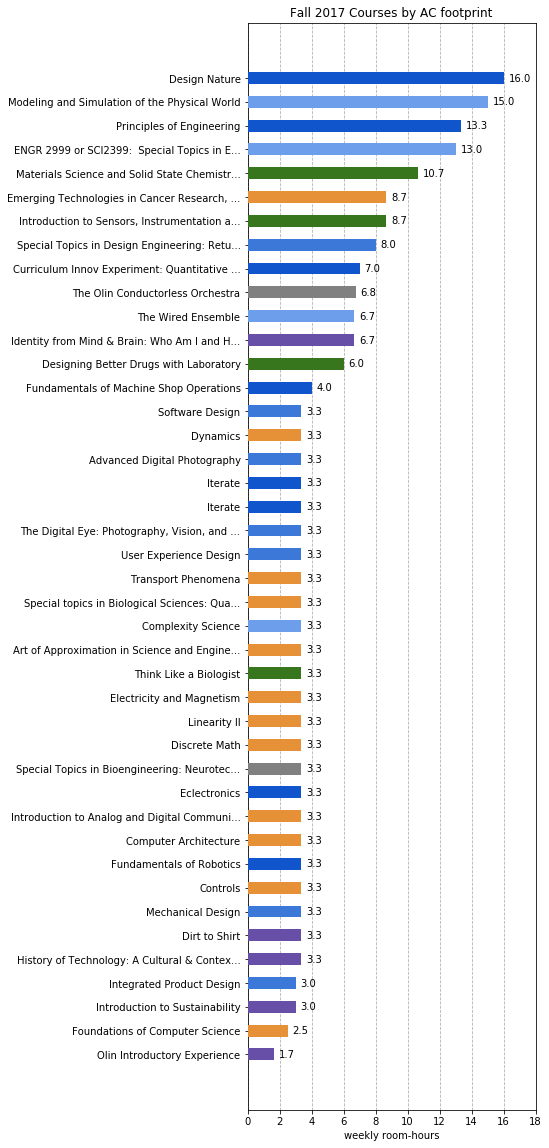

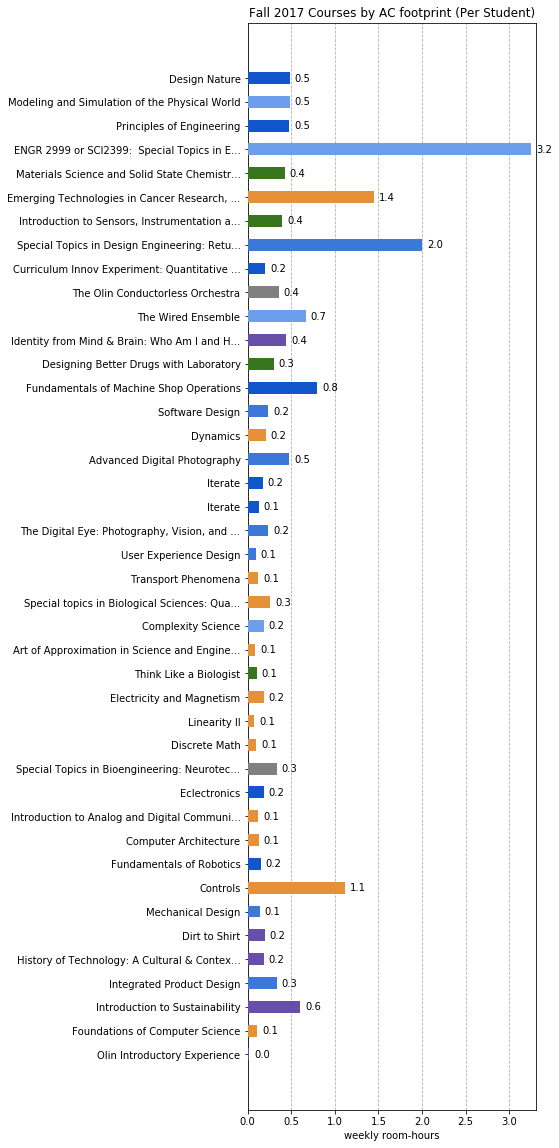

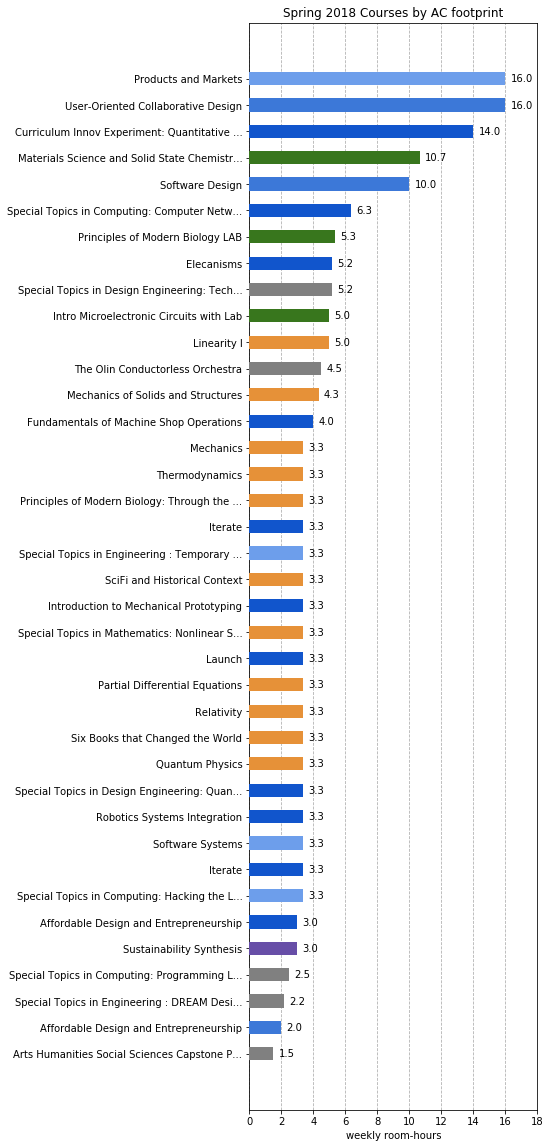

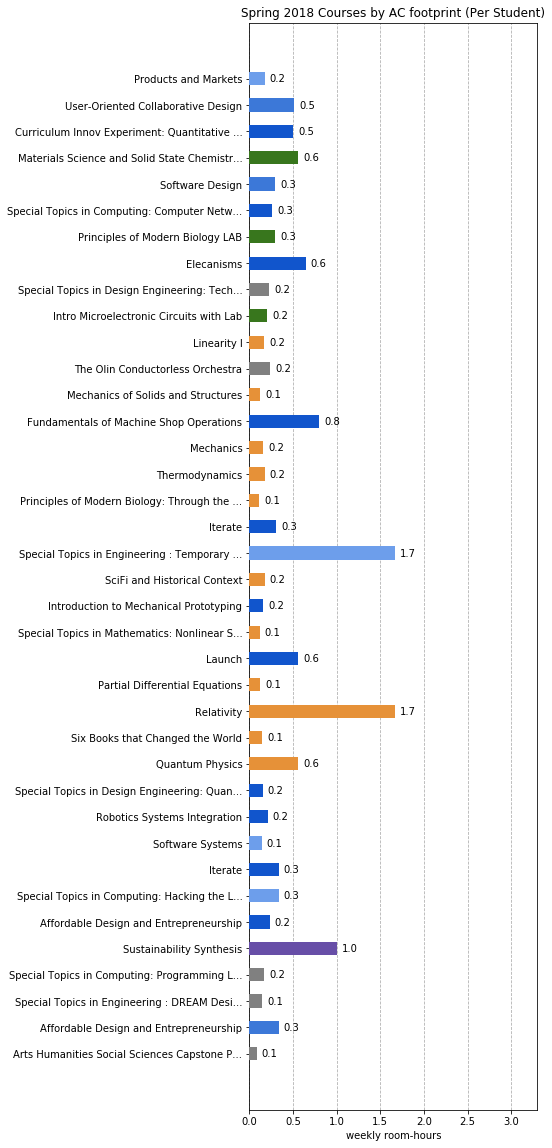

In [178]:
def plot_courses_bar(courses, normed=False):
    def format_titles(titles):
        # parse out course title
        extractor = re.compile('^(?:(\w{3,4} ?\d{0,5}\w?)[:|/] )?(.*)$')
        just_titles = [extractor.match(a).group(2) for a in titles]
        # trim length of strings
        max_len = 45
        abbr_titles=[a[:max_len-3]+'...' if len(a) > max_len else a for a in just_titles]
        return abbr_titles
    
    if normed:
        bar_data = (courses['Weekly Length'] / pd.Timedelta(1, unit='h'))/courses['Registered Students']
    else:
        bar_data = courses['Weekly Length'] / pd.Timedelta(1, unit='h')

    return adastra.plot_barh(
        labels=format_titles(courses['Course Title'].astype(str)),
        values=bar_data,
        color=[category_colors.get(category, 'grey') for category in courses['Primary Category']],
        fig = plt.figure(figsize=(10,20))
    )

for name, data in footprints:
    for normed in [False, True]:
        fig = plot_courses_bar(data[data['Primary Category'] != 'NOT IN AC'][pd.notnull(data['Course Title'])].sort_values('Weekly Length'), normed)
        if normed:
            plt.xlim([0, 3.3])
            plt.title(name+' Courses by AC footprint (Per Student)')
            fname=name.lower().strip(' ')+'_courses_footprint_per_student'+'.eps'
        else:
            plt.xlim([0,18])
            plt.title(name+' Courses by AC footprint')
            fname=name.lower().strip(' ')+'_courses_footprint'+'.eps'
            
        plt.xlabel('weekly room-hours')
        fig.subplots_adjust(left=0.5)  # make room for the course labels
        plt.savefig('figs/'+fname)

In [ ]:
sp18courses[sp18courses['Course/Customer'] == 'ENGR2510']